# Processamento de Dados Geoespaciais – NDVI Sentinel-2
Este notebook demonstra como:
- Ler uma imagem Sentinel-2 (GeoTIFF)
- Extrair bandas específicas (Red e NIR)
- Calcular NDVI (Normalized Difference Vegetation Index)
- Salvar o resultado em GeoTIFF
- Criar um shapefile com áreas de NDVI alto (>0.5)
- Visualizar resultados no Python e exportar para QGIS

In [24]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from rasterio.features import shapes
from shapely.geometry import shape

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


1️⃣ Ler a Imagem GeoTIFF

In [25]:
# Caminho para o seu arquivo recém-criado
caminho_sentinel = "../data/sentinel.tif"

try:
    with rasterio.open(caminho_sentinel) as src:
        print(f"✅ Arquivo '{caminho_sentinel}' aberto com sucesso.")
        print(f"Dimensões: {src.width}x{src.height} pixels")
        print(f"Número de bandas: {src.count}")
except rasterio.errors.RasterioIOError as e:
    print(f"❌ Erro ao abrir o arquivo: {e}")
    print("Verifique se o arquivo 'sentinel.tif' existe no caminho especificado.")


✅ Arquivo '../data/sentinel.tif' aberto com sucesso.
Dimensões: 7661x7761 pixels
Número de bandas: 2


2️⃣ Extrair Bandas RED e NIR

In [28]:
# Extrair as bandas necessárias
with rasterio.open(caminho_sentinel) as src:
    # Banda Vermelha (RED) na posição 1
    red_band = src.read(1).astype('float32')
    
    # Banda Infravermelho Próximo (NIR) na posição 2
    nir_band = src.read(2).astype('float32')
    
    # Obter o perfil (metadados) para salvar o novo arquivo
    profile = src.profile

print("✅ Bandas RED e NIR extraídas com sucesso!")



✅ Bandas RED e NIR extraídas com sucesso!


3️⃣ Calcular NDVI (Normalized Difference Vegetation Index)
Fórmula:
NDVI = (NIR - Red) / (NIR + Red)

In [29]:
# Evitar divisão por zero, substituindo zeros por NaN
np.seterr(divide='ignore', invalid='ignore')
ndvi = (nir_band - red_band) / (nir_band + red_band)

# Limitar os valores de NDVI entre -1 e 1
ndvi[np.isnan(ndvi)] = 0
ndvi[ndvi > 1] = 1
ndvi[ndvi < -1] = -1

print("✅ NDVI calculado com sucesso!")

✅ NDVI calculado com sucesso!


4️⃣ Salvar o Resultado em GeoTIFF

In [31]:
# Atualizar o perfil para o novo arquivo GeoTIFF
profile.update(
    dtype=rasterio.float32,
    count=1,
    nodata=None
)

caminho_ndvi = "../data/ndvi.tif"
with rasterio.open(caminho_ndvi, 'w', **profile) as dst:
    dst.write(ndvi, 1)

print(f"✅ Arquivo '{caminho_ndvi}' criado com sucesso!")

✅ Arquivo '../data/ndvi.tif' criado com sucesso!


5️⃣ Visualizar o NDVI

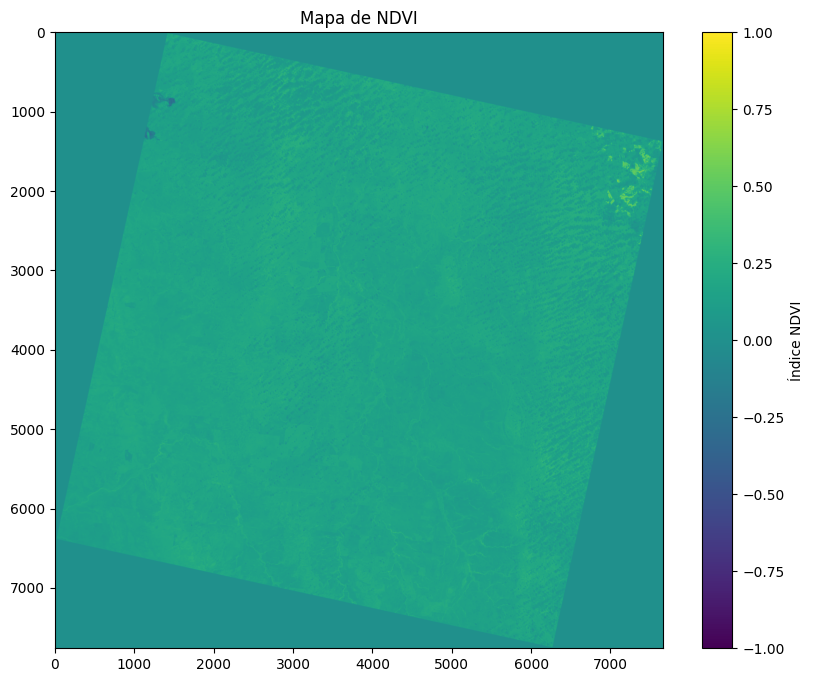

✅ Mapa de NDVI exibido com sucesso!


In [32]:
plt.figure(figsize=(10, 8))
plt.title("Mapa de NDVI")
plt.imshow(ndvi, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Índice NDVI')
plt.show()

print("✅ Mapa de NDVI exibido com sucesso!")

6️⃣ Criar um Shapefile com Áreas de NDVI Alto.

In [34]:
# Criar uma máscara binária para áreas com NDVI > 0.5
mask_ndvi = ndvi > 0.5

# Converter o raster (máscara) em geometrias vetoriais
with rasterio.open(caminho_ndvi) as src:
    results = ({'properties': {'raster_val': v}, 'geometry': s}
               for i, (s, v) in enumerate(shapes(mask_ndvi.astype('uint8'), mask=mask_ndvi, transform=src.transform)))
    
    geoms = list(results)
    
    # Criar um GeoDataFrame com as geometrias
    gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)

    # Salvar o GeoDataFrame em um shapefile
    caminho_shapefile = "../data/areas_ndvi_alto.shp"
    gdf.to_file(caminho_shapefile, driver='ESRI Shapefile')

print(f"✅ Shapefile '{caminho_shapefile}' criado com sucesso!")



✅ Shapefile '../data/areas_ndvi_alto.shp' criado com sucesso!


7️⃣ Visualizar o Resultado Final (Raster e Vetor)

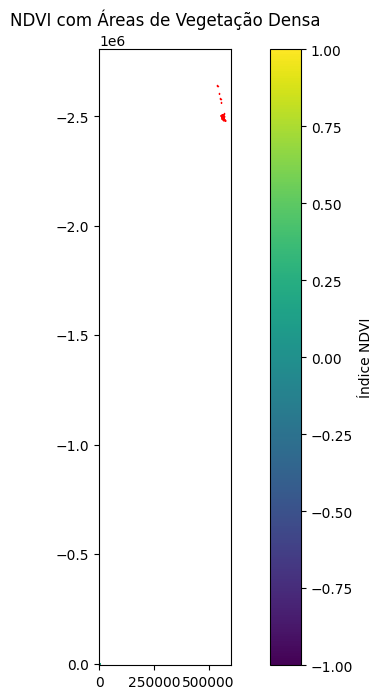

✅ Visualização completa!


In [35]:
plt.figure(figsize=(10, 8))

# Plotar o raster NDVI
plt.imshow(ndvi, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Índice NDVI')
plt.title("NDVI com Áreas de Vegetação Densa")

# Plotar o shapefile sobre o raster
gdf.plot(ax=plt.gca(), color='none', edgecolor='red', linewidth=1)

plt.show()

print("✅ Visualização completa!")